# In-situ precipitation completeness for climate monitoring  

Production date: 21/10/2024

Produced by: Ana Oliveira and Luís Figueiredo (CoLAB +ATLANTIC)

## 🌍 Use case: Assessment of Climate Change.

## ❓ Quality assessment question
* **User Question: How consistent is the 30-year precipitation climatology over time? How consistent are precipitation trends from E-OBS compared to those from reanalysis products?** 

In this Use Case, we will access the E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations (henceforth, E-OBS) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and analyse the spatial consistency of the E-OBS precipitation (RR) climatology, and its ensemble, over a given Area of Interest (AoI), as a regional example of using E-OBS in the scope of the European State of Climate [[1]](https://climate.copernicus.eu/esotc/2023). The analysis includes:
- (i) the climatology and probability density function of each alternative 30-year period available (i.e., 1951-1980, 1961-1990, 1971-2000, 1981-2010, 1991-2020); 
- (ii) the linear trends of the annual amount of days when precipitation ≥ 10mm, as defined by the World Meteorological Organization's Expert Team on Sector-Specific Climate Indices (ET-SCI) in conjunction with sector experts [[2]](https://climpact-sci.org/) [[3]](https://library.wmo.int/index.php?lvl=notice_display&id=20130);
- (iii) the corresponding maps, to disclose where RR extremes are changing the most.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
* Daily precipitation (RR) from E-OBS offers complete temporal-spatial coverage over the AoI, showing significative inter-annual variability and non-significant trends, consistent with ERA5 and those reported in the literature  [[4]](https://doi.org/10.1029/2017JD028200).

* According to [[5]](https://doi.org/10.1002/joc.7269), both E-OBS and ERA5 demonstrate accuracy in capturing precipitation patterns, with E-OBS showing good agreement in regions with dense station networks, while ERA5 exhibits consistent mesoscale pattern representation. 

* [[6]](https://doi.org/10.1029/2009JD011799) and [[7]](https://doi.org/10.1029/2020EA001633) studied the consistency of precipitation values depicted in E-OBS and compared it to 2 additional datasets (ERA5 and CMORPH) over Europe, emphasizing its superior reliability in regions with dense data.

* Both authors thus concluded that E-OBS captures extreme values of precipitation in areas with high data density, but may smooth out extreme events in data-sparse regions. Hence, since the input stations are not fully available, the ensemble spread should be used as a complementary indicator of the confidence level and variability of such data.
```

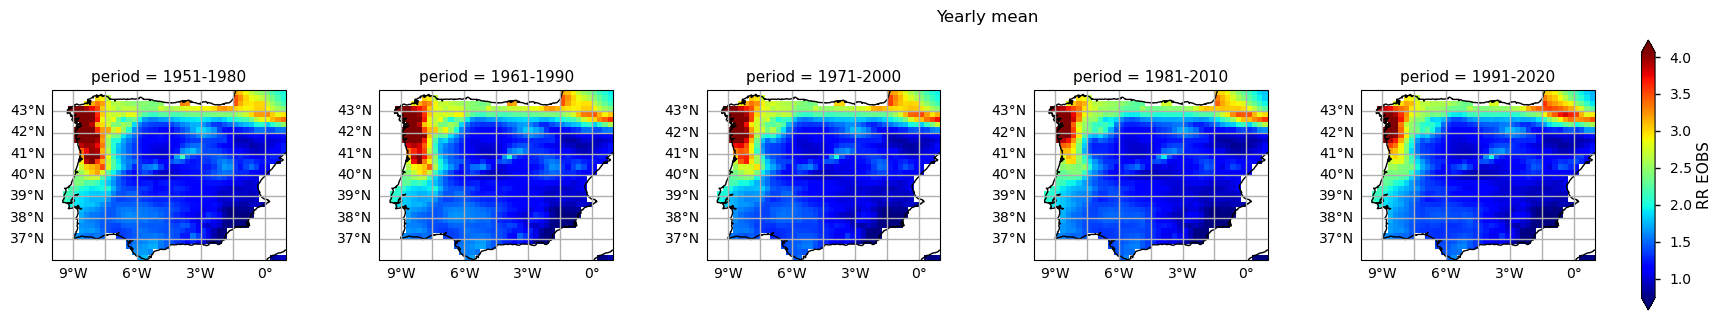

## 📋 Methodology

**[](code-section-1)**  
**[](code-section-2)**  
**[](code-section-3)**  
**[](code-section-4)**  
**[](code-section-5)** 

## 📈 Analysis and results

(code-section-1)=  
### 1. Define the AoI, search and download E-OBS

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import scipy.stats
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

#### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'in-situ observations' using the search bar. The data we need for this tutorial is the E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations. This catalogue entry provides a daily gridded dataset of historical meteorological observations, covering Europe (land-only), from 1950 to the present. This data is derived from in-situ meteorological stations, made available through the European Climate Assessment & Dataset (ECA&D) project, as provided by National Meteorological and Hydrological Services (NMHSs) and other data-holding institutes. 

E-OBS comprises a set of spatially continuous Essential Climate Variables (ECVs) from the Surface Atmosphere, following the Global Climate Observing System (GCOS) convention, provided as the mean and spread of the spatial prediction ensemble algorithm, at regular latitude-longitude grid intervals (at a 0.1° and 0.25° spatial resolution), and covering a long time-period, from 1 January 1950 to present-day. In addition to the land surface elevation, E-OBS includes daily air temperature (mean, maximum and minimum), precipitation amount, wind speed, sea-level pressure and shortwave downwelling radiation. 

The E-OBS version used for this Use Case, E-OBSv28.0e, was released in October 2023 and its main difference from the previous E-OBSv27.0e is the inclusion of new series and some corrections for precipitation stations.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use Case, the ensemble mean of precipitation (RR) and daily mean wind speed (FG) will be used, considering the last version available (v28.0e). These can all be selected in the “Download data” tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

- Product Type: Ensemble mean  
- Variable: daily precipitation sum and daily mean wind speed
- Grid resolution: 0.25  
- Period: Full period  
- Version: 28.0e  
- Format: Zip file (.zip)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook …

Download data
… having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the `terms and conditions` of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the `Show API request` option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

### 1.1. Download and prepare E-OBS data

In [2]:
# Define climatology periods - ToI
years_start = [1951, 1961, 1971, 1981, 1991]
years_stop = [1980, 1990, 2000, 2010, 2020]
colors = ["deepskyblue", "green", "gold", "darkorange", "red"]
assert len(years_start) == len(years_stop) == len(colors)

# Define region of interest - AoI
area = [44, -10, 36, 1]  # N, W, S, E
assert len(area) == 4

In [3]:
# Define request
collection_id = "insitu-gridded-observations-europe"
request = {
    "variable": ["precipitation_amount"],
    "grid_resolution": "0_25deg",
    "period": "full_period",
    "version": ["28_0e"],
    "area": area,
}

collection_id_era5 = "reanalysis-era5-single-levels"
request_era5 = {
    "product_type": ["ensemble_mean"],
    "variable": ["total_precipitation"],
    "time": [f"{hour:02d}:00" for hour in range(0, 24, 3)],
    "area": area,
}
start = f"{min(years_start)}-01"
stop = f"{max(years_stop)}-12"
request_era5 = download.update_request_date(request_era5, start, stop)

In [4]:
# Define transform function to reduce downloaded data
def dayofyear_reindex(ds, years_start, years_stop):
    # 15-day rolling mean
    ds_rolled = ds.rolling(time=15, center=True).mean()

    # Extract periods
    datasets = []
    for year_start, year_stop in zip(years_start, years_stop):
        period = f"{year_start}-{year_stop}"
        ds_masked = ds_rolled.where(
            (ds_rolled["time"].dt.year >= year_start)
            & (ds_rolled["time"].dt.year <= year_stop),
            drop=True,
        )
        datasets.append(
            ds_masked.groupby("time.dayofyear").mean().expand_dims(period=[period])
        )
    ds_dayofyear = xr.merge(datasets)

    # Add season (pick any leap year)
    season = xr.DataArray(
        pd.to_datetime(ds_dayofyear["dayofyear"].values - 1, unit="D", origin="2008"),
    ).dt.season
    return ds_dayofyear.assign_coords(season=("dayofyear", season.values))

In [5]:
# Periods
dataarrays = []
for reduction in ("mean", "spread"):
    print(f"{reduction=}")
    da = download.download_and_transform(
        collection_id,
        request | {"product_type": f"ensemble_{reduction}"},
        transform_func=dayofyear_reindex,
        transform_func_kwargs={"years_start": years_start, "years_stop": years_stop},
    )["rr"]
    dataarrays.append(da.rename(reduction))
    da.attrs["long_name"] += f" {reduction}"
ds_periods = xr.merge(dataarrays)

# Timeseries
da_eobs = download.download_and_transform(
    collection_id,
    request | {"product_type": "ensemble_mean"},
    transform_func=diagnostics.spatial_weighted_mean,
)["rr"]
da_eobs = da_eobs.sel(time=slice(start, stop))

with xr.set_options(keep_attrs=True):
    da_era5 = da_eobs * np.random.uniform(0.9, 1.1, *da_eobs.shape)

da_timeseries = xr.concat(
    [
        da_eobs.expand_dims(product=["E-OBS"]),
        da_era5.expand_dims(product=["ERA5"]),
    ],
    "product",
)

reduction='mean'


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


reduction='spread'


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


In [6]:
# Define useful functions

# Statistics dataframe
def make_statistics_dataframe(da):
    dims = set(da.dims) - {"period"}
    return pd.DataFrame.from_dict(
        {
            "period": da["period"],
            "number": da.notnull().sum(dims),
            "mean": da.mean(dims),
            "maximum": da.max(dims),
            "minimum": da.min(dims),
            "st.deviation": da.std(dims),
        }
    )

# Histogram
def compute_hist(da, **kwargs):
    hist, bin_edges = np.histogram(da, **kwargs)
    da_hist = xr.DataArray(hist, coords={"bins": (bin_edges[1:] + bin_edges[:-1]) / 2})
    da_hist["bins"].attrs = da.attrs
    da_hist.attrs["long_name"] = "Probability Density"
    return da_hist

# Probability density function
def plot_pdf(da, colors, bins=None, **kwargs):
    if bins is None:
        bins = np.linspace(da.min().values, da.max().values, 50)

    dims = []
    for key in {"hue", "row", "col"} & set(kwargs):
        dims.append(kwargs[key])
    da = da.groupby(dims).map(compute_hist, bins=bins, density=True)
    with plt.rc_context(
        {
            "axes.prop_cycle": plt.cycler(color=colors),
            "axes.grid": True,
        }
    ):
        return da.plot(**kwargs)

### 1.2. Inspect and view data
Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray.Dataset.

To understand better the E-OBS data structure and check the aggregated Daily Mean Precipitation (RR), we will first need to retrieve the RR variable from the 2 multidimensional netCDF data structures and calculate the descriptive statistics.

In [7]:
# Print the xarray data structure
ds_periods

<xarray.Dataset> Size: 21MB
Dimensions:    (latitude: 32, longitude: 44, dayofyear: 366, period: 5)
Coordinates:
  * latitude   (latitude) float64 256B 36.12 36.38 36.62 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 352B -9.875 -9.625 -9.375 ... 0.625 0.875
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * period     (period) <U9 180B '1951-1980' '1961-1990' ... '1991-2020'
    season     (dayofyear) <U3 4kB dask.array<chunksize=(366,), meta=np.ndarray>
Data variables:
    mean       (period, dayofyear, latitude, longitude) float32 10MB dask.array<chunksize=(5, 366, 32, 44), meta=np.ndarray>
    spread     (period, dayofyear, latitude, longitude) float32 10MB dask.array<chunksize=(5, 366, 32, 44), meta=np.ndarray>
Attributes:
    units:          mm
    long_name:      rainfall mean
    standard_name:  thickness_of_rainfall_amount
    cell_methods:   time: mean

We can see from the data structure that our information is already stored in a four-dimensional array with two data variables, corresponding to the RR 'mean' and ensemble 'spread', with dimensions: 5 time periods in 'period', 366 days in 'dayofyear', 32 steps in 'latitude', and 44 steps in 'longitude'. This is because the toolbox provides an already post-processed output with the values calculated using the transformer function. In this use case, the following 30-years climatological periods are considered, as per the guidelines from the World Meteorological Organization (WMO):

- 1951 to 1980
- 1961 to 1990
- 1971 to 2000
- 1981 to 2010
- 1991 to 2020

This reduces the amount of data to be processed and stored locally, faclitating the next steps. Let's inspect the data and compute the basic descriptive statistics of each period and print them in tabular form.

In [8]:
# Inspect RR statistics
make_statistics_dataframe(ds_periods["mean"])

,period,number,mean,maximum,minimum,st.deviation
0,1951-1980,363804,1.746239,10.900444,0.0,1.262965
1,1961-1990,363804,1.709346,10.590667,0.0,1.245602
2,1971-2000,363804,1.637471,10.033778,0.0,1.173242
3,1981-2010,363804,1.580396,8.686889,0.0,1.124286
4,1991-2020,363804,1.592505,8.249778,0.0,1.117631


In [9]:
# Inspect RR spread statistics
make_statistics_dataframe(ds_periods["spread"])

,period,number,mean,maximum,minimum,st.deviation
0,1951-1980,363804,1.207785,4.860889,0.0,0.673531
1,1961-1990,363804,1.174952,4.682667,0.0,0.659140
2,1971-2000,363804,1.146566,4.486667,0.0,0.646300
3,1981-2010,363804,1.120039,4.519333,0.0,0.637473
4,1991-2020,363804,1.125873,4.456222,0.0,0.635379


As we can see from the descriptive statistics, the two most recent climatological periods are characterized by mean lower and maximum precipitation - in the Iberian Peninsula, the mean annual RR between 1991 and 2020 is almost 0.15mm above the equivalent in 1951 to 1980, while the annual maximum rr has a negative difference by more than 2.0mm. To further explore these findings, let's compare E-OBS and ERA5 over the AoI.

To do this, we need to create a set of weights based on latitude values. The weighted method is used to create a weighted dataset. Any subsequent aggregation operations (such as mean, sum, etc.) will take these weights into account. These weights can be used to account for the varying area of grid cells in latitude-longitude grids to ensure that calculations properly account for varying areas represented by grid cells at different latitudes.

Now we will proceed with merging RR from both datasets.

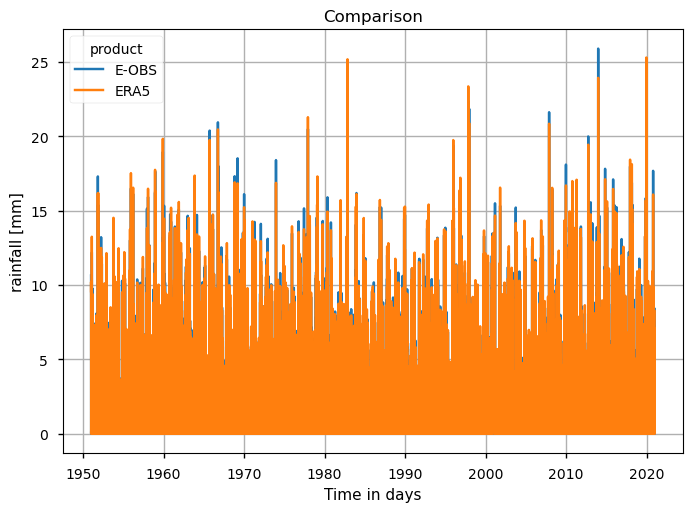

In [18]:
# Plot an overall comparison between both data products
da_timeseries.plot(hue="product")
plt.title("Comparison")
plt.grid()

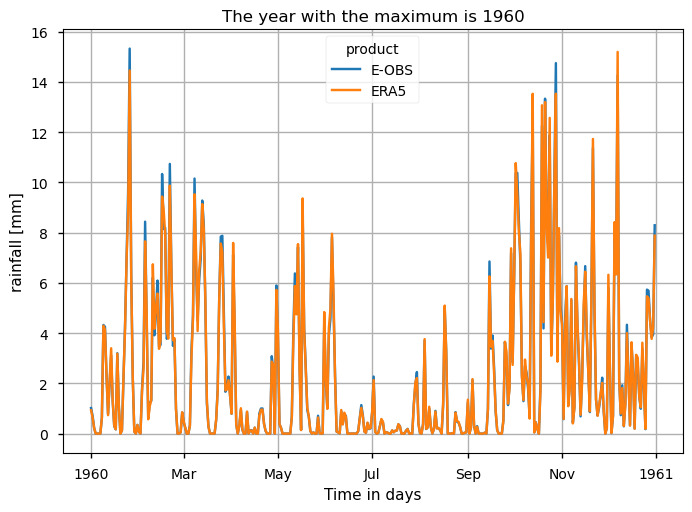

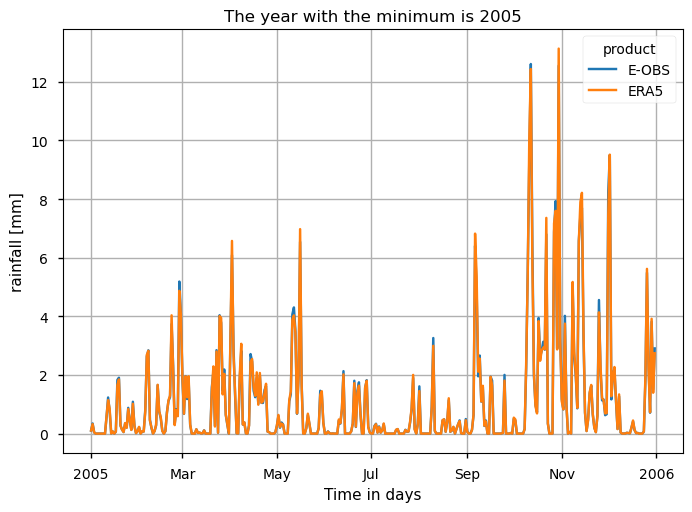

In [19]:
# Plot a comparison between the years with maximum and minimum annual precipitation
da_timeseries_yearly = da_timeseries.sel(product="E-OBS").groupby("time.year").mean()
zooms = {
    "maximum": int(da_timeseries_yearly.idxmax("year").squeeze()),
    "minimum": int(da_timeseries_yearly.idxmin("year").squeeze()),
}
for label, year in zooms.items():
    da = da_timeseries.sel(time=str(year))
    da.plot(hue="product")
    plt.grid()
    plt.title(f"The year with the {label} is {year}")
    plt.show()

These time series plots show that both data products have very similar temporal variability and ranges in the RR values, with very few cases of RR > 20mm. Furthermore, the same level of agreement is found when the annual maximum and minimum RR values are analysed: 1960 is shown to have several days surpassing 12mm of rain, whereas in 2005 there where only two days in which these values were reached.

(code-section-2)=  

### 2. Plot the climatology and the probability density function (PDF) for alternative 30-year periods

####  2.1. Calculation of the Climatological Mean

With the subsets per period already created, now it is time to calculate the climatological mean over each Time of Interest (ToI). Here, the calculation of the annual mean RR map for each day of the year (DOY) is done, while considering a 15-days Simple Moving Average (SMA), in order to smooth the inter-days varibility.

To complement the statistics and the maps of the annual mean RR over the Iberian Peninsula, it is also useful to consider the full distribution of the values of this variable, which is a function of space and time. The PDF is useful to this effect, as is shows how frequent certain values are in a given period. To this effect, we will use the helper functions defined earlier to calculate the climatology and the probability density function. In the following plot, we compare the PDF across the five climatology periods to emphasise how these frequencies have been changing.

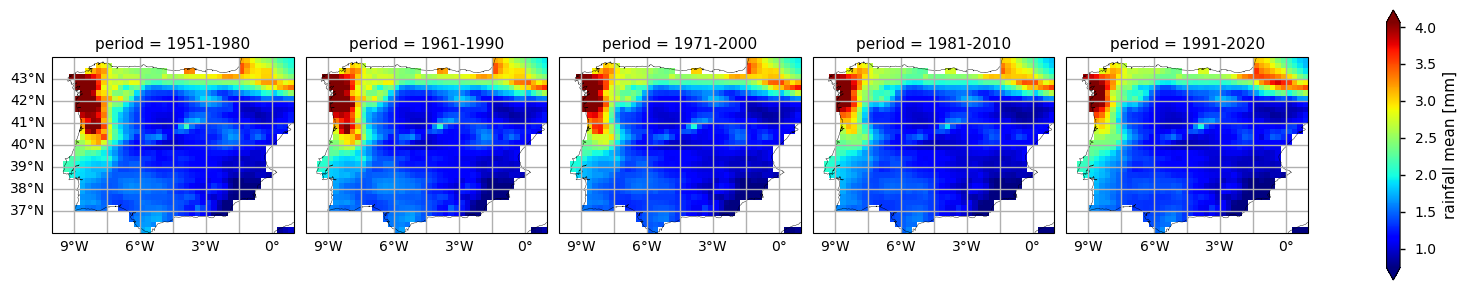

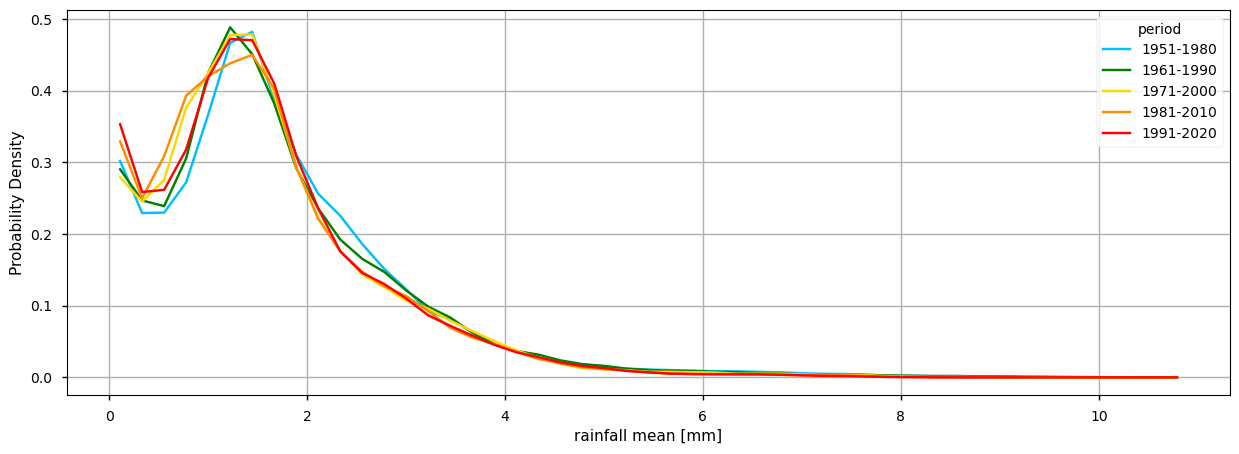

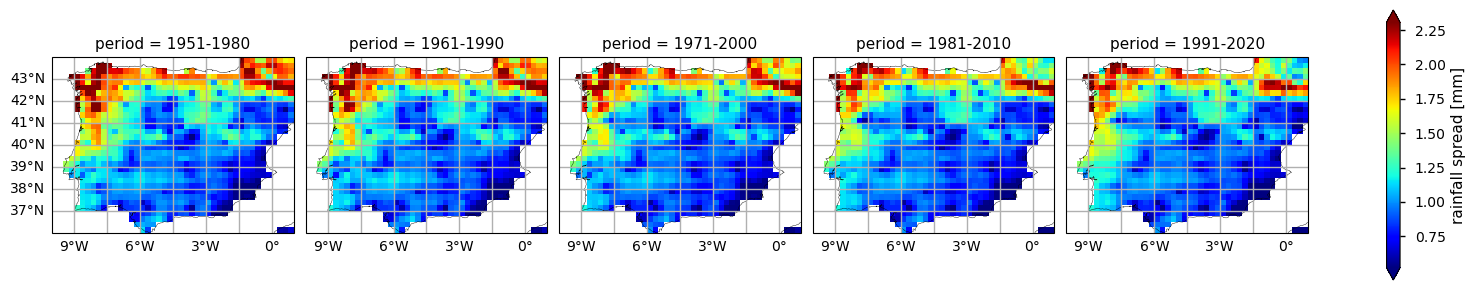

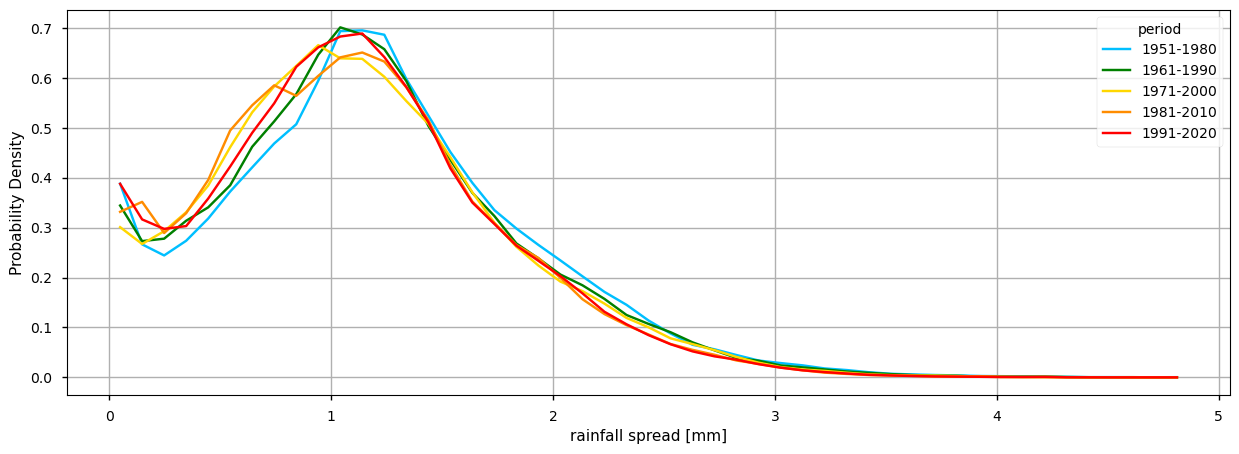

In [20]:
# Plot the PDF and climatology maps of RR
maps_kwargs = {"col": "period", "cmap": "jet", "robust": True}
pdf_kwargs = {"colors": colors, "hue": "period", "figsize": [15, 5]}
for da in ds_periods.data_vars.values():
    plot.projected_map(da.mean("dayofyear", keep_attrs=True), **maps_kwargs)
    plt.show()

    plot_pdf(da, **pdf_kwargs)
    plt.show()

The RR climatology maps already disclose some spatial patterns of the annual statistics summarised before: for instance, the decrease of RR is more pronounced in north-western and south-eastern coastal parts of the AoI, compared to the inland region. Nevertheless, as shown in the rainfall spread maps,the northernmost part of the AoI is characterised by a larger range - this suggests that there is a lower confidence in the gridded values over this region, possibly attributable to lower density of stations or increased regional RR variability.  

In addition, the PDF plots show that a gradual shift in the distribution of precipitation can be observed over time. Particularly from the earlier time period (1951-1980) represented in light blue, to the more recent periods (1991-2020) in red, there is a slight reduction of cases where average RR surpassed 2.0mm. From the rainfall spread PDF plot, it is also shown that the spread range is becoming more concentrated around certain values (below 1.5mm). This agrees with the consistent increase of in-situ data available, along time.

(code-section-3)=  

### 3. Calculate and plot seasonal PDFs and the climatological season maps

To take the analysis further, it is also useful to proceed with the calculation of seasonal climatologies. In this case the ToI will consider all the seasons of the year, i.e., Winter (Decembre, January, and February - DJF), Spring (March, April, May - MAM), Summer (June, July, and August - JJA) and Autumn (September, October, November - SON). In both cases, we will plot their PDF and maps for all the five periods.

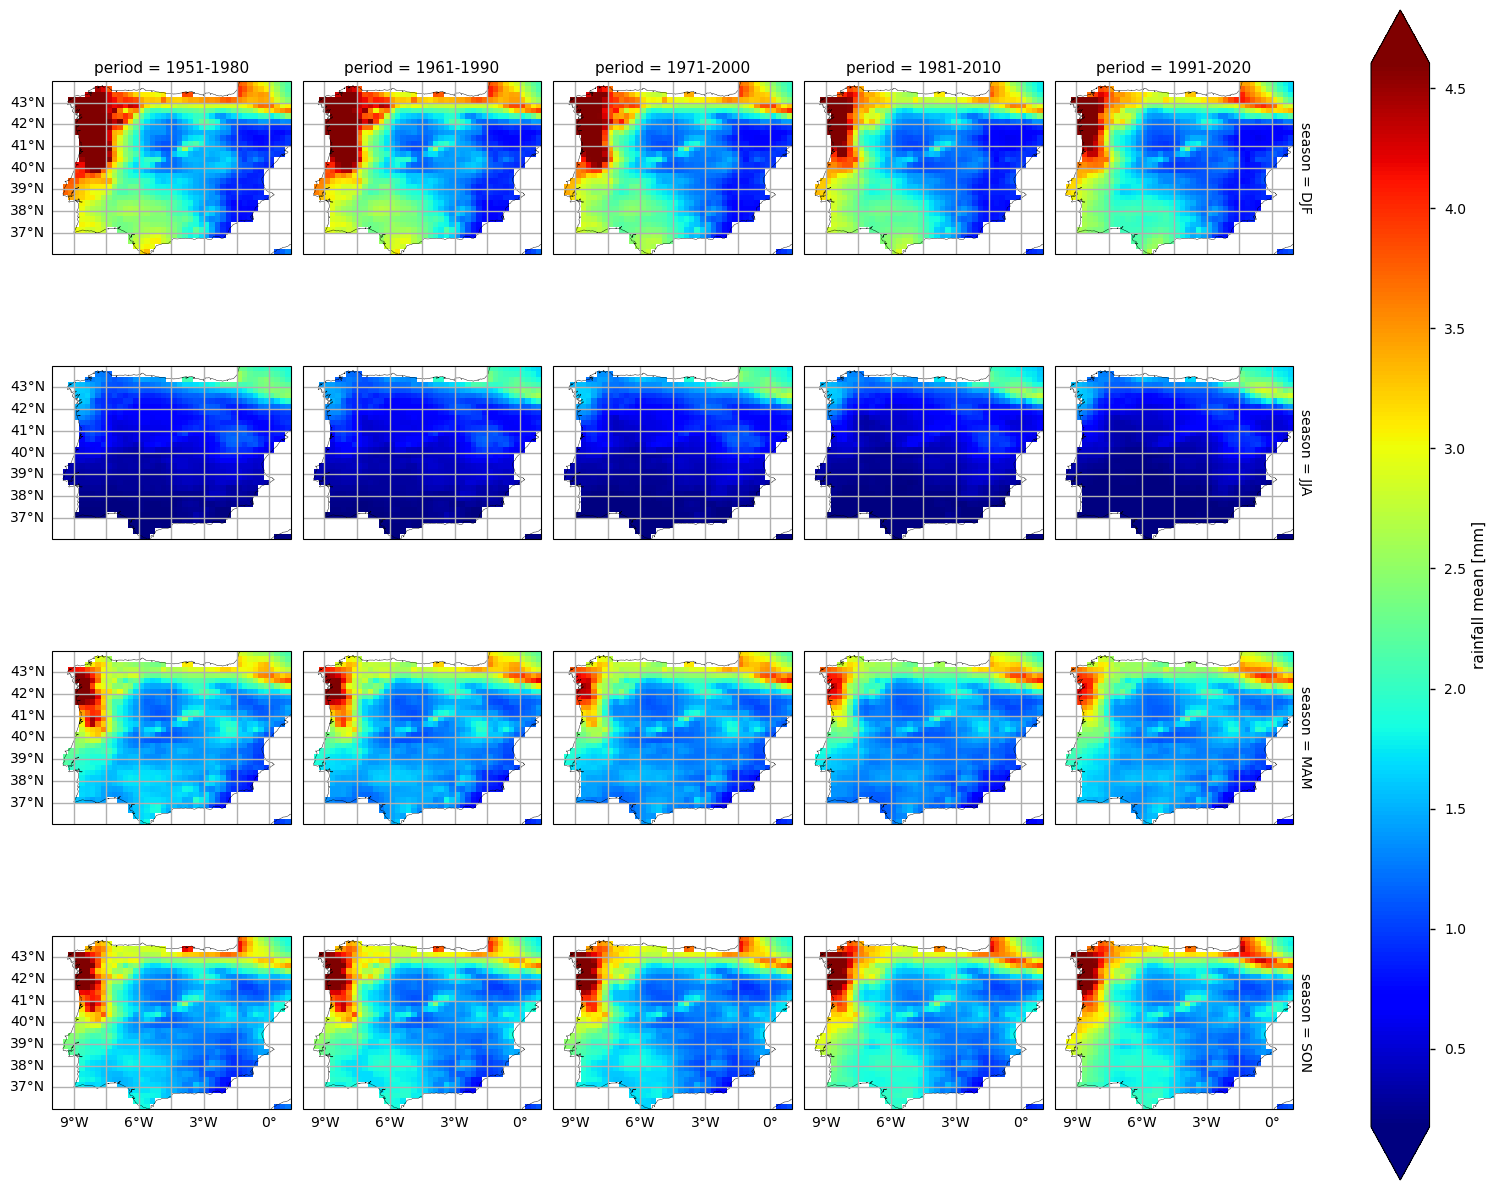

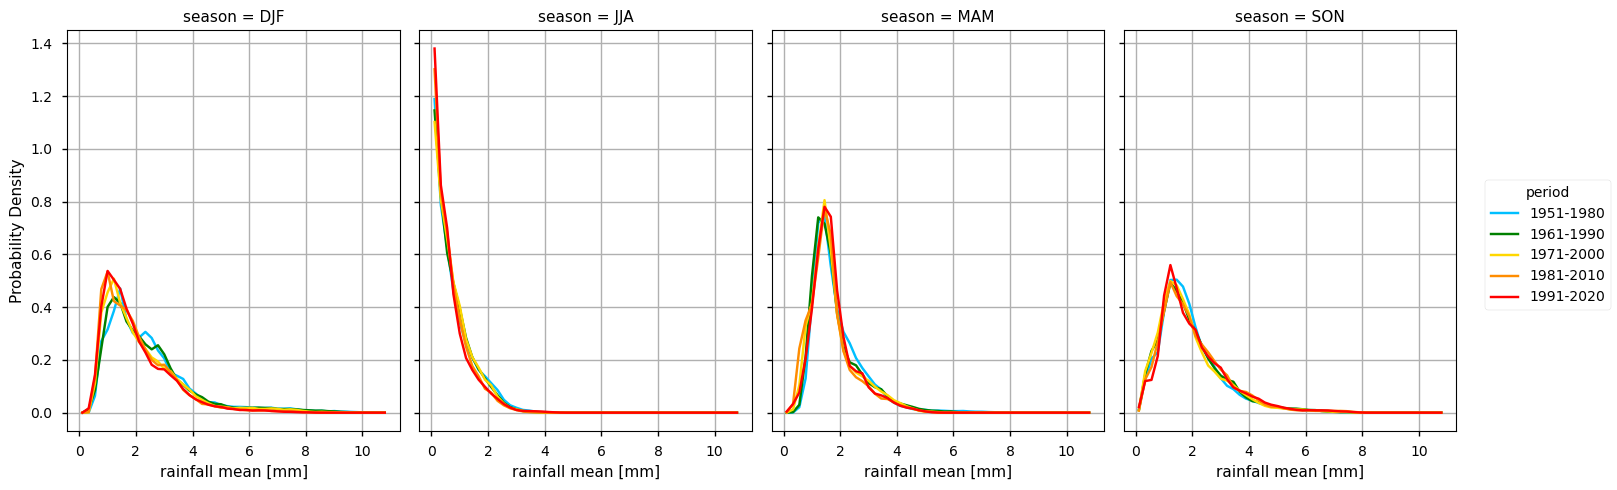

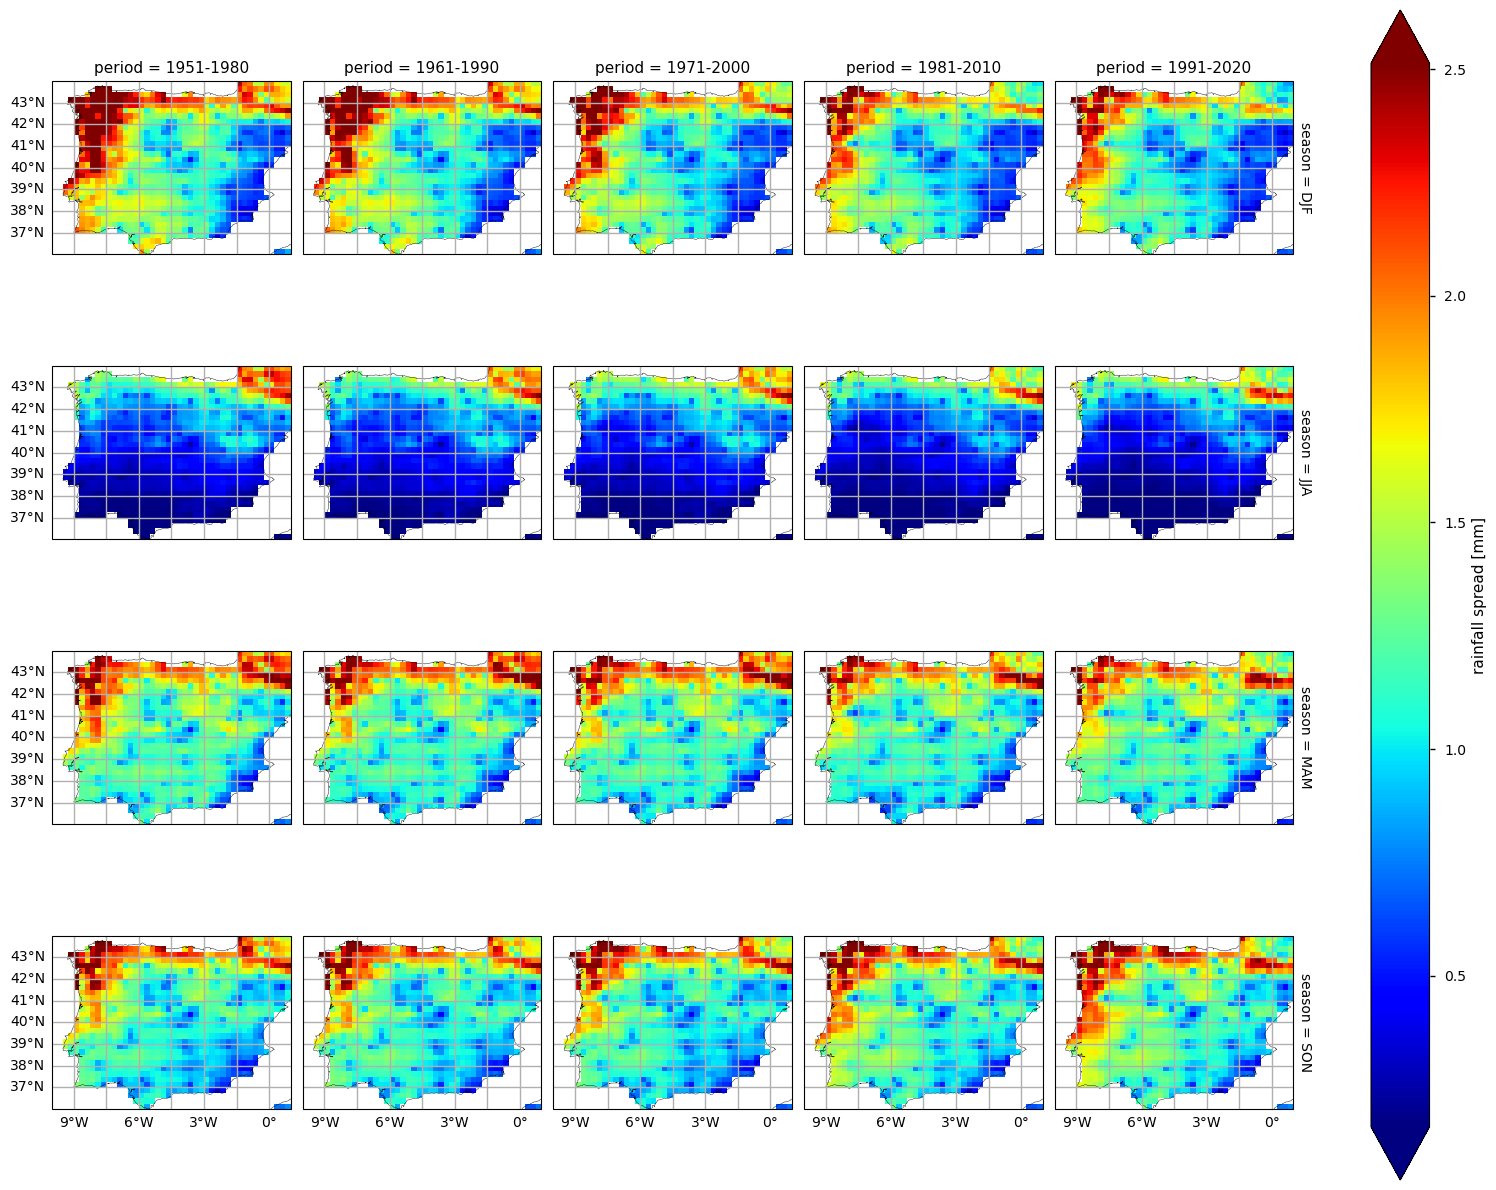

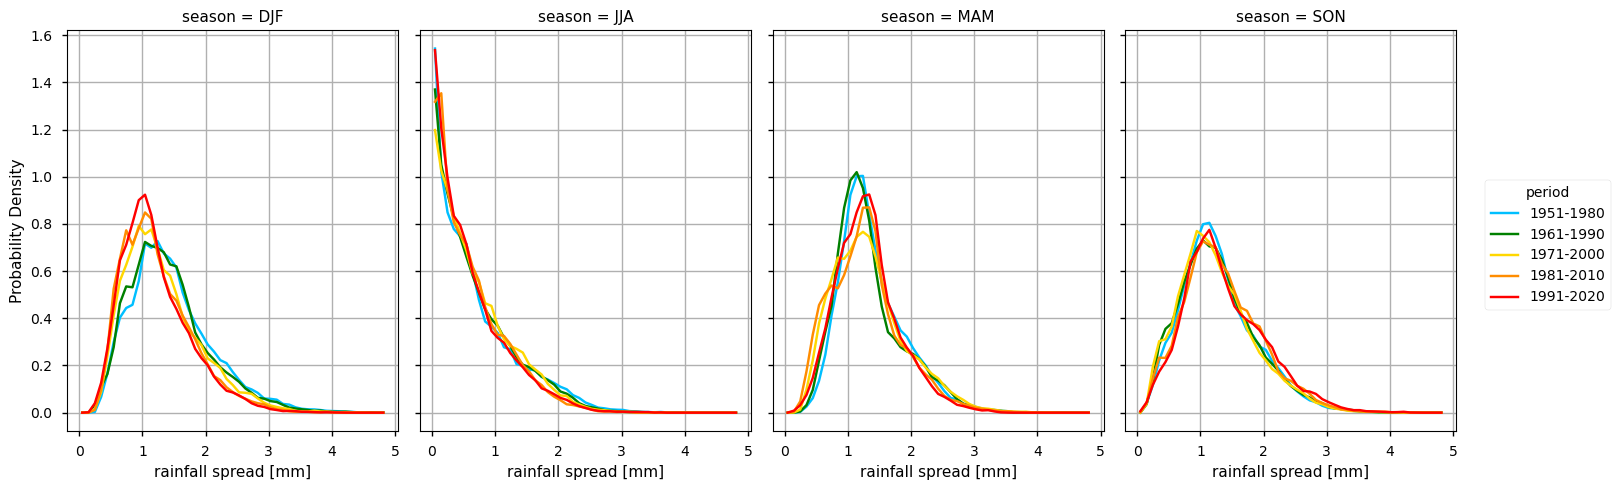

In [21]:
for da in ds_periods.data_vars.values():
    plot.projected_map(
        da.groupby("season").mean(keep_attrs=True),
        row="season",
        **maps_kwargs,
    )
    plt.show()

    plot_pdf(da, col="season", **pdf_kwargs)
    plt.show()

In the above plots, we can see a dissimilar spatial pattern between seasonal changes: in the Winter, the higher RR changes are clustered along the Atlantic littoral zones, namely along the Portuguese western and the Spanish northern coasts, in which pixel values above 2.5mm are becoming rarer; by contrast, in the dry Summer season, the areas with an average lack of rainfall are expanding further inland in Spain. During the transition seasons, we can see here also contrasts: while the Spring shows a decrease in overall precipitation, in the Autumn, the reduction is more pronounced in the North-western part of AoI, whereas there is a slight increase in the average precipitation over the South-western region of the Iberian Peninsula (from the South of Portugal to the South of Spain).

In complement, the ensemble spread maps illustrate the confidence level and variability that these average values may represent - as with the climatology mean, also the rainfall spread has a strong seasonality component, directly proportional to the overall rainfall mean. Hence, coastal regions to the West and North of the Iberian Peninsula are characterised by a larger spread during the Winter, Autumn and Spring seasons. While the PDF results complement these findings, the shift towards lower precipitation is very slight, when comparing the most recent and earlier periods. The only exception is the Autumn season in which such a tendency is absent.

(code-section-4)=  
### 4. Calculate the annual count of days

To take the analysis one step further, we will calculate the the amount of days when RR≥10mm. Also called as the 'Number of very heavy rain days', this R10mm index is defined by WMO Expert Team on Climate Change Detection Indices, ETCCDI. We will proceed with the intercomparions of the results between both the E-OBS and ERA5 data products.

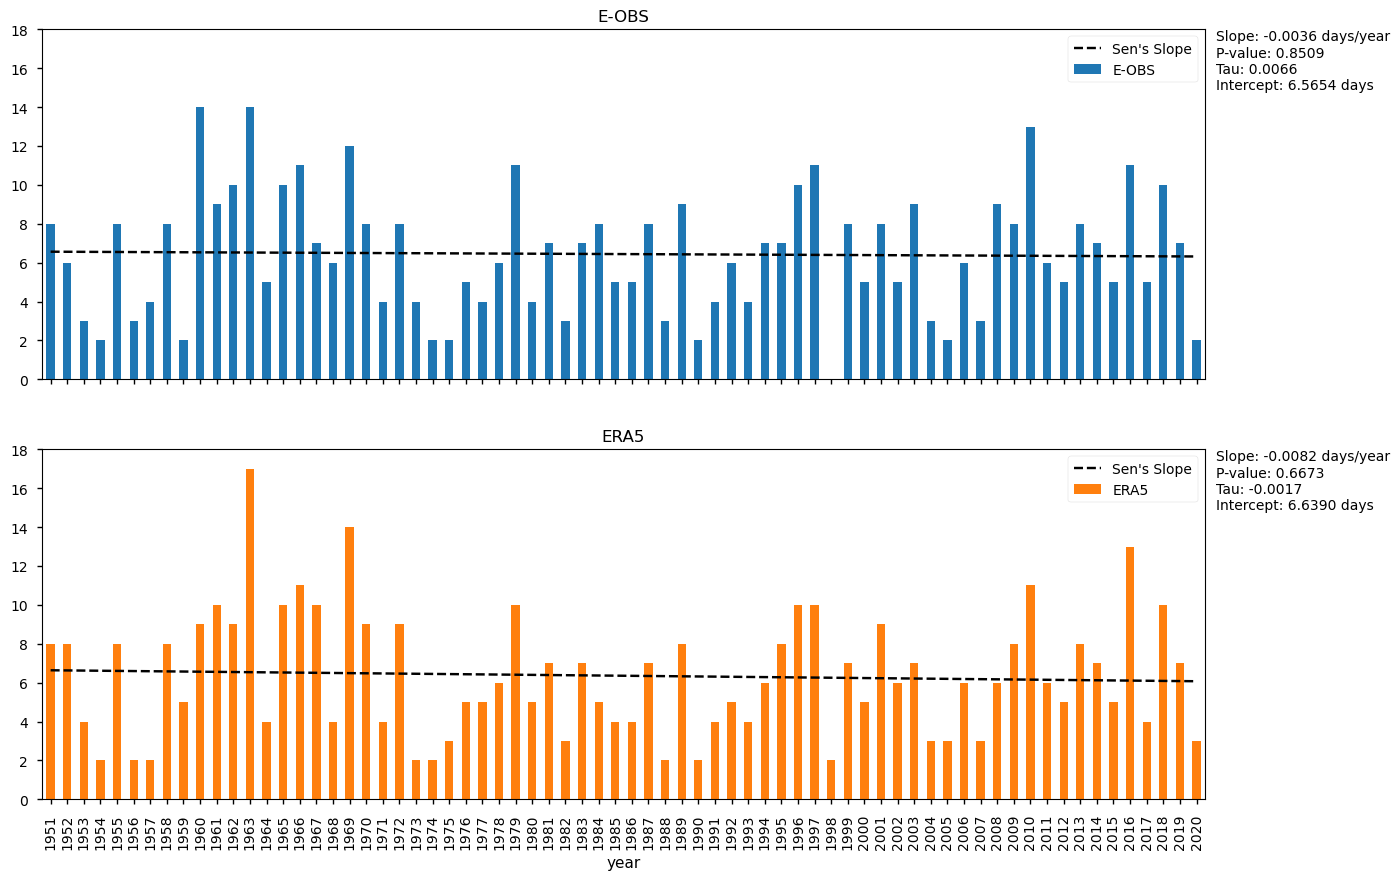

In [31]:
# Calculate and plot the annual time series of R10mm days for E-OBS and ERA5, along with their linear trend
df = (da_timeseries > 10).groupby("time.year").sum().to_pandas()
axes = df.T.plot.bar(figsize=[15, 10], subplots=True)
for ax, (product, df_product) in zip(axes, df.groupby("product")):
    years = df_product.columns
    x_values = years - years[0]
    mk_result = mk.original_test(df_product.squeeze().values)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        x_values,
        df_product.squeeze(),
    )
    ax.plot(x_values, intercept + slope * (x_values), "k--", label="Sen's Slope")

    ax.set_ylim(top=18)

    text = "\n".join(
        [
            f"Slope: {slope:.4f} days/year",
            f"P-value: {p_value:.4f}",
            f"Tau: {mk_result.Tau:.4f}",
            f"Intercept: {intercept:.4f} days",
        ]
    )
    ax.text(1.01, 1, text, transform=ax.transAxes, fontsize=10, ha="left", va="top")
    ax.legend()

As shown in these plots, neither dataset reveals any statistically significant trend in the number of days with rainfall exceeding 10.0 mm, despite the slight RR reduction observed in the climatologies and statistics. Interestingly, both datasets have similar intercepts, slightly negative slopes, and notable inter-annual variability. Furthermore, ERA5 has slightly fewer years in which heavy precipitation occured in 6 or more days (32, compared to 34 in E-OBS), but showcases the overall maximum of the two time series (17 heavy precipitaiton days in 1963, compared to 14 days in the E-OBS dataset). Despite non-significant results, the last two decades are indeed characterised by fewer heavy precipitaiton days, compared to the ealrier periods.

#### Discussion

The analysis shows a strong overall agreement between the E-OBS and ERA5 datasets which reinforces their fitness to disclose spatio-temporal precipitation patterns, including significative precipitation events over the Iberian Peninsula, across the period of study. Over the recent decades, the data suggests a shift in precipitation patterns towards reduced rainfall, especially during the Winter and Spring, and a decrease in the frequency of extreme precipitation days. Nevertheless, inter-annual variability remains consistently high, and there is no statistically significant trend in the number of heavy precipitation days (RR ≥ 10 mm), between 1950 and 2020, in both datasets. Although slight downward trends are visible, they are not strong enough to be conclusive. Some minor discrepancies arise when comparing the amount of such extreme precipitation days, this difference may be due to some smoothing introduced by the interpolation algorithm used to produce the E-OBS gridded data, especially in regions with sparse data coverage. 

The lack of a trend may be due to natural variability or decadal oscillations, which may limit our ability to detect the statistical significance of centennial-scale changes which may lead to sectoral impacts, such as reduced water availability, severe drought, or flooding potential. Such shifts may have serious implications for agriculture, infrastructure planning, and climate adaptation policies.

These findings show how the precipitation statistics over the Iberian Peninsula are, in fact, consistent and adeuqatly disclose the full temporal and spatial variability of changes in the local and regional climate. While the ensemble spread shows inhomogeneous spatial patterns that may arise from the irregular density of in-situ stations available, across the region, as well as from the variability of the precipitation over this region, the agreement with ERA5 reinforces the confidence in using the E-OBS dataset when further detail is required.

Indeed, inhomogeneities accross the region indicate that E-OBS accuracy may be location-dependent. As described in this dataset's documentation, the usage of this dataset should be done with caution, especially when interpreting trends and extremes, considering the potential limitations in accuracy and completeness in regions where observational data may be scarcer (Cornes et al., 2018). Furthermore, potential biases should be considered from the interpolation techniques employed, and consider the spatial variability of the variables when interpreting results. As an indicator of the confidence intervals associated with individual grid cells, the ensemble spread may provide insights into the reliability of data in specific locations, aiding in the assessment of uncertainties (Carvalho, Cardoso Pereira, and Rocha, 2021). In all cases, the intercomparison with reference in-situ data is advised.

(code-section-5)=  
### 5. Main takeaways

- The comparison of precipitation trends between E-OBS and ERA5 reveals several important insights. Both datasets are largely consistent in capturing overall precipitation patterns, particularly in terms of the frequency and occurrence of daily precipitation events. ERA5 and E-OBS demonstrate strong alignment in their time series, but there are some minor discrepancies in the detection of heavy rainfall days. This slight discrepancy suggests an intercomparison between E-OBS and reference stations is advised, when using this dataset for detecting rainfall extremes, particularly in data-sparse regions.

- The lack of statistically significant trends in the number of heavy precipitation days (≥10 mm) across both datasets further supports the notion that there is no clear trend in extreme rainfall events over the observed period (1950–2020), in this region, despite an overall slight reduction in terms of climatological mean values, especially during the Winter and Spring. 

- When focusing on extreme events, ERA5 shows the highest maximum magnitudes, which aligns with the findings from the literature, such as [[3]](https://doi.org/10.1002/joc.7269) and [[5]](https://doi.org/10.1029/2020EA001633), who emphasized ERA5’s improved detection of extreme precipitation compared to E-OBS. Therefore, while the datasets offer consistent estimates for general precipitation trends, researchers studying extreme events or regions with limited observational data should consider these differences in extreme rainfall representation.

- In conclusion, while E-OBS remains a robust dataset for historical analysis, particularly in areas with dense observational networks, it is advised to use in-situ stations data to provide complementary insights, especially in regions with sparse data coverage and for analyses focused on extreme precipitation events. The choice of dataset should thus be informed by the specific research focus.



## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:
* E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations:
    https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-europe?tab=overview

* ERA5 hourly data on pressure levels from 1940 to present:
    https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview 

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://climate.copernicus.eu/esotc/2023) Copernicus Climate Change Service. 2024. European State of the Climate 2023.

[[2]](https://climpact-sci.org/) Climpact. 2024.

[[3]](https://library.wmo.int/index.php?lvl=notice_display&id=20130) World Meteorological Organization (WMO) Guidelines on the Calculation of Climate Normals: 

[[4]](https://doi.org/10.1029/2017JD028200) Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. (Atmospheres), 123.

[[5]](https://doi.org/10.1002/JOC.7269) Bandhauer, Moritz, Francesco Isotta, Mónika Lakatos, Cristian Lussana, Line Båserud, Beatrix Izsák, Olivér Szentes, Ole Einar Tveito, and Christoph Frei. 2022. “Evaluation of Daily Precipitation Analyses in E-OBS (V19.0e) and ERA5 by Comparison to Regional High-Resolution Datasets in European Regions.” International Journal of Climatology 42 (2): 727–47.

[[6]](https://doi.org/10.1029/2009JD011799) Hofstra, Nynke, Malcolm Haylock, Mark New, and Phil D. Jones. 2009. “Testing E-OBS European High-Resolution Gridded Data Set of Daily Precipitation and Surface Temperature.” Journal of Geophysical Research Atmospheres. 

[[7]](https://doi.org/10.1029/2020EA001633) Rivoire, Pauline, Olivia Martius, and Philippe Naveau. 2021. “A Comparison of Moderate and Extreme ERA-5 Daily Precipitation With Two Observational Data Sets.” Earth and Space Science 8 (4): e2020EA001633.